In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import copy

action2vect = {0: np.array([0, -1]),
               1: np.array([0, +1]),
               2: np.array([-1, 0]),
               3: np.array([+1, 0])
               }

a2m = {0:'up', 1:'down', 2:'left', 3:'right'}

def random_initialize(Maze, threshold):
    x = np.random.randn(Maze.lx*Maze.ly).reshape(Maze.lx, Maze.ly)
    y = (x < threshold)*(x > -threshold)
    Maze.tile = y
    Maze.load_tile()
    
    floor_labels = np.arange(len(Maze.floors))
    start_floor_label = np.random.choice(floor_labels)
    goal_floor_label = np.random.choice(floor_labels)
    Maze.goal = Maze.floors[goal_floor_label].tolist()
    return Maze
        
class MazeEnv():
    def __init__(self, lx, ly, threshold=0.9, figsize=5, const=0):
        self.lx, self.ly = lx, ly
        
        self = random_initialize(self, threshold)
        self.reset()
        
        self.action_space = [0,1,2,3]
        self.status = 'Initialized'
        self.figsize = figsize

        self.reward_const = const
        self.reward_goal = 1
        self.reward_usual = 0
    def reset(self, coordinate=[None, None]):
        """
        put the agent at certain coordinate randomly.
        """
        floor_labels = np.arange(len(self.floors))
        start_floor_label = np.random.choice(floor_labels)
        self.state = self.floors[start_floor_label]
        self.status = 'Reset'
        self.t = 0
        return self.get_state()
        
    def is_solved(self):
        return self.goal==self.state.tolist()
    
    def get_state(self):
        return copy.deepcopy(self.state)#
            
    def get_next_state(self, state, action):
        add_vector_np = action2vect[action]
        if (state+add_vector_np).tolist() in self.floors.tolist():
            next_state = state+add_vector_np
            self.status = 'Moved'
        else:
            next_state = state
            self.status = 'Move failed'
        self.t += 1
        return next_state
    
    def get_reward(self, state, action, state_p):
        if state_p.tolist()==self.goal:
            reward = self.reward_goal
        elif False:
            reward = 0.1
        else:
            reward = self.reward_usual
        return reward + self.reward_const
    
    def step(self, action):
        state = self.get_state()
        next_state = self.get_next_state(state, action)
        reward = self.get_reward(state, action, next_state)
        self.state = next_state
        return self.get_state(), reward, self.is_solved(), {}
        
    def load_tile(self):
        self.floors = np.array(list(np.where(self.tile==True))).T # (#white tiles, 2), 2 means (x,y) coordinate
        self.holes = np.array(list(np.where(self.tile==True))).T # (#black tiles, 2)
    
    def render_tile(self, ax, cmap='gray'):
        ax.imshow(self.tile.T, interpolation="none", cmap=cmap, vmin=0, vmax=1)
        return ax
    
    def render_arrows(self, ax, values_table):
        lx, ly, _ = values_table.shape
        vmins = np.min(values_table, axis=2).reshape(lx, ly, 1)
        offset = - vmins
        vnoed = values_table*self.tile.reshape(lx, ly, 1) + offset 
        vnoed_maxs = np.max(vnoed, axis=2).reshape(lx, ly, 1)
        vt = np.transpose(vnoed/(vnoed_maxs), (1,0,2))
        width = 0.5
        X, Y= np.meshgrid(np.arange(0, lx, 1), np.arange(0, ly, 1))
        ones = .5*np.ones(lx*ly).reshape(lx, ly)
        zeros= np.zeros(lx*ly).reshape(lx, ly)
        ax.quiver(X, Y, zeros, ones, vt[:,:,0], alpha=0.8, cmap='Reds', scale_units='xy', scale=1) # up
        ax.quiver(X, Y, zeros, -ones, vt[:,:,1], alpha=0.8, cmap='Reds', scale_units='xy', scale=1)# down
        ax.quiver(X, Y, -ones, zeros, vt[:,:,2], alpha=0.8, cmap='Reds', scale_units='xy', scale=1)# left
        ax.quiver(X, Y, ones, zeros, vt[:,:,3], alpha=0.8, cmap='Reds', scale_units='xy', scale=1) # right
        return ax
        
    def render(self, fig=None, ax=None, lines=None, values_table=None, canvas=False):
        if ax is None:
            fig = plt.figure(figsize=(self.figsize, self.figsize))
            ax = fig.add_subplot(111)
            ax.set_xlabel('x'); ax.set_ylabel('y')
        ax = self.render_tile(ax)
        if values_table is not None:
            ax = self.render_arrows(ax, values_table)
        if self.goal is not None:
            ax.scatter(self.goal[0], self.goal[1], marker='d', s=100, color='red', alpha=0.8, label='goal')
        if self.state is not None:
            ax.scatter(self.state[0], self.state[1], marker='o', s=100, color='black', alpha=0.8, label='agent')
        if lines is not None:
            lc = mc.LineCollection(lines, linewidths=2, color='black', alpha=0.5)
            ax.add_collection(lc)   
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', scatterpoints=1)
        if canvas:
            return ax
        else:
            plt.show()
                      
    def play(self, Agent, show=True, fig=None, ax=None, canvas=False):
        lines = []
        while not self.is_solved():
            state0 = self.get_state()
            action = Agent.play()
            self.step(action)
            state1 = self.get_state()
            lines.append([state0, state1])
        if show:
            return self.render(fig=fig, ax=ax, lines=lines, canvas=canvas)

## 9-2. マルコフ決定過程

### 迷路の環境
ここでは迷路(Grid world)の環境を使って強化学習の手法を説明します。環境は`MazeEnv(xサイズ, yサイズ, 簡単さを表す数値)`で作れるようにしておきました：

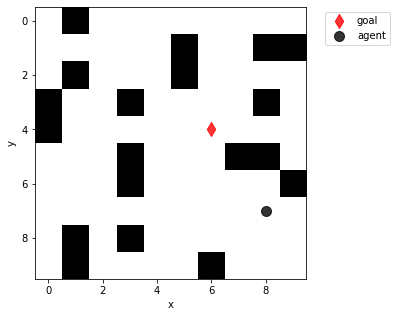

In [15]:
env = MazeEnv(10, 10, threshold=1.3)
env.render()

ここで◾は通れない壁、$\color{red}{◆}$ は迷路のゴール地点を表すとします。また、●がエージェントの位置を表します。

#### エージェント
早速この迷路を探索するエージェントを作ってみます：

In [16]:
class Agent():
    def __init__(self, policy):
        self.policy = policy
        
    def play(self):
        """
        return a number in [0,1,2,3] corresponding to [up, down, left, right]
        """
        return self.policy.sample()

##### 取れる行動
迷路のルールを体感するために、自分で操作できるような方策を作ってみます。エージェントは 0,1,2,3 の数字のどれかを各ステップで選択します。それぞれ

- 0:up, 1:down, 2:left, 3:right

への移動を表します。

In [17]:
class Policy():
    def __init__(self, env):
        self.env = env
        
    def sample(self):
        a = int(input(" ".join(["{}:{},".format(n, a2m[n]) for n in range(4)]) + "\n "))
        return a

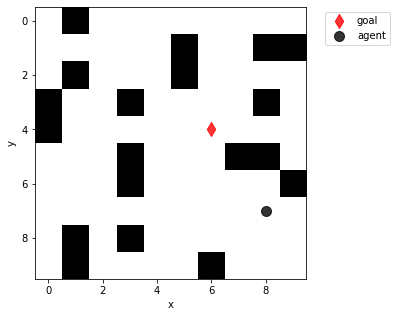

0:up, 1:down, 2:left, 3:right,
 0
env.step(a)= (array([8, 6]), 0, False, {})


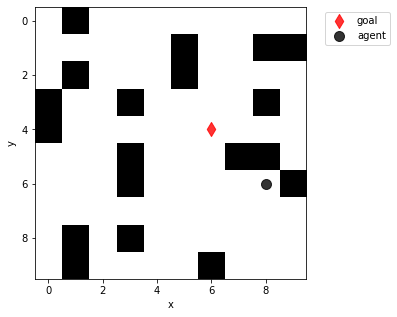

In [18]:
agent = Agent(policy=Policy(env))
env.render()
a = agent.play()
print("env.step(a)=", env.step(a))
env.render()

##### 最後までプレイさせるコマンド
ちなみに 
- `env.play(agent)` 

でゴールするまでプレイし続けることができます。手で入力は面倒なので、ランダムな方策を使ってみましょう





In [19]:
class Random(Policy):
    def __init__(self, env):
        self.A = env.action_space 
        
    def sample(self):
        return np.random.choice(self.A)

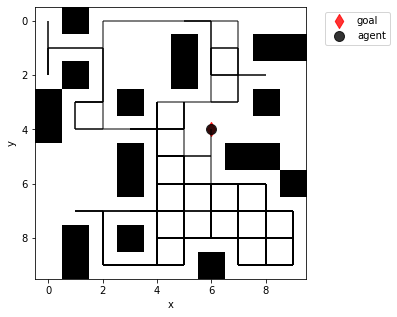

In [20]:
agent = Agent(policy=Random(env))
env.play(agent)

ランダムウォークなので、右往左往した後ゴールしている様子がわかります。注意ですが、作った迷路によっては**絶対にゴールできない状況** があり得るので、そのような不運な場合には上のセルの実行はいつまで経っても終わりません。

#### 環境

##### 1時刻進める関数

行動 `a` を入力して、現在の状態を更新し、1時刻進める関数が `env.step(a)` です。加えてこの関数は返り値があり、

- `env.step(a)= (a行動後のエージェント位置座標[x, y], 報酬, ゴールしたか, {})` 

です。

agent coordinate [2 6]


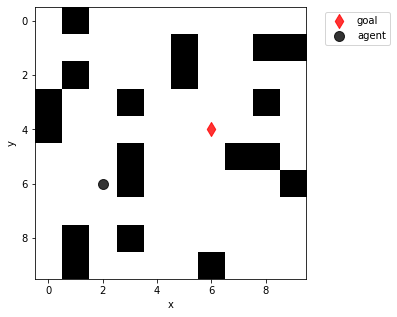

a = 1 = down
env.step(a)= (array([2, 7]), 0, False, {})


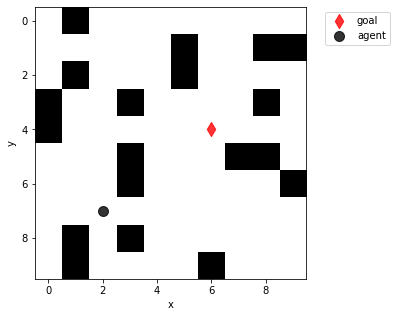

agent coordinate [2 7]


In [22]:
env.reset()
print("agent coordinate", env.state)
agent = Agent(policy=Random(env))
env.render()
a = agent.play()
print('a =', a, '=', a2m[a])
print("env.step(a)=", env.step(a))
env.render()
print("agent coordinate", env.state)

こんな感じで、

1. エージェント位置 $s_0 = [x_0, y_0]$
2. エージェント行動 $a_0 \to $ エージェント位置 $s_1 = [x_1, y_1]$, 報酬 $r_1$
3. エージェント行動 $a_1 \to $ エージェント位置 $s_2 = [x_2, y_2]$, 報酬 $r_2$
4. ...

を繰り返してゆきます。

### マルコフ決定過程


ここまでで、迷路の環境やエージェントについて説明してきましたが、数学的な状況を説明しましょう。

#### 変数

- **状態**: $s = [x,y]$
- **行動**: $a = 0,1,2,3$
- **報酬**: $r = 0, 1$ (ゴールの場合1それ以外0 $^※$)

まず、エージェントの位置を表す座標 [x, y] ですが、このようなエージェントの状態を表す変数を**状態(state)**といい、だいたい$s$で表します。
次に、エージェントが各時刻で起こす行動に対応する変数を**行動(action)**といい、$a$で表します。
最後に、エージェントの行動に応じて得られる**報酬(reward)**を$r$で表します。

> $^※$ じつは、このようにせず、「ゴールするまで負の報酬」としても良いです。こちらのほうが負の報酬＝罰則をくらいたくないため、強化学習アルゴリズムによっては「なるべく早くゴールしようとする」傾向が見られます。

#### エージェントの方策と行動
上では、エージェントオブジェクトにポリシー(方策)を読み込んでいましたが、方策は数学的には「状態$s$が与えられたときの行動$a$の確率」

$$
\pi(a|s)
$$

で表します。状態$s$での実際の行動はこの確率からのサンプリングと解釈します：

$$
a \sim \pi(\cdot|s)
$$

ランダムな方策は例えば $\pi(a|s) = \frac{1}{4}$ というわけです。

#### 環境の時間発展
環境にも確率が設定されており、
- $s_{t+1} \sim P_s(\cdot|s_t, a_t)$
- $r_{t+1} \sim P_r(\cdot|s_t, a_t, s_{t+1})$

であると解釈します。

#### マルコフ決定過程
適当な初期値から初めて、エージェントの方策による行動サンプル＋環境の時間発展を繰り返した時系列(迷路では`env.play(agent)`に対応する)

$$
\left. \begin{array}{ll:ll:ll:ll}
s_0 
\overset{\pi(\cdot|s_0)}{\to}
&
a_0 
\overset{P_s(\cdot|s_0, a_0)}{\to} 
&
s_1 
&
\overset{\pi(\cdot|s_1)}{\to}
a_1  
\overset{P_s(\cdot|s_1, a_1)}{\to} 
&
s_2
&
\overset{\pi(\cdot|s_2)}{\to}
a_2
\overset{P_s(\cdot|s_2, a_2)}{\to} 
&
 \cdots
\\
\downarrow_{P_r(\cdot|-, -, s_0)} 
&&
\downarrow_{P_r(\cdot|s_0, a_0, s_1)} 
&&
\downarrow_{P_r(\cdot|s_1, a_1, s_2)} 
\\
r_0
&
&
r_1
&
&
r_2
\end{array} \right.
\tag{1.3}
$$

を**マルコフ決定過程(Markov Decision Process, MDP)**といいます。ゲームが始まってから終わるまでの1単位（**MDP**の1つのサンプル系列）を**エピソード(episode)**と呼びます。

強化学習は基本的にはこの MDP を前提とし、その中でエージェントをいかに制御するかを考えます。

### 価値観数とベルマン方程式


#### 行動価値関数 $q_*(s,a)$

バンディット問題での行動価値は、実際に得られる報酬の期待値でした。今回の場合は、同じ行動でも、その行動を取る状態に依存して価値が変わります。例えば以下のような２つの状況を考えてみます：

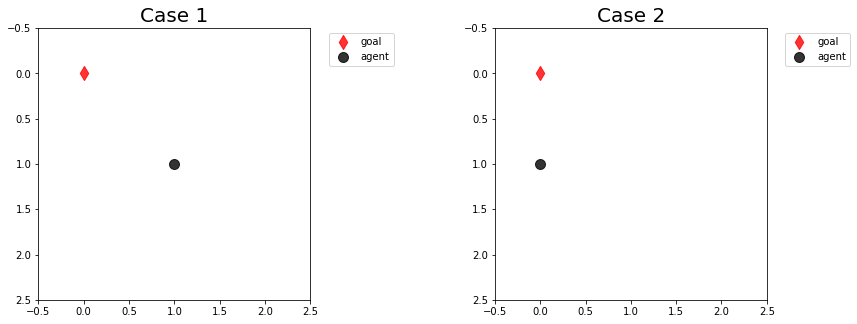

In [14]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121); ax1.set_title("Case 1", fontsize=20) 
ax2 = fig.add_subplot(122); ax2.set_title("Case 2", fontsize=20) 

env = MazeEnv(3, 3, threshold=10); env.goal=[0,0];  env.state=[1,1]
env.render(ax=ax1, fig=fig, canvas=True)

env = MazeEnv(3, 3, threshold=10); env.goal=[0,0];  env.state=[0,1]
env.render(ax=ax2, fig=fig)

**Case 1(左図)** でのエージェントが $a=0$(up) としても、ゴールにはたどり着かないので今の環境では報酬が与えられません。一方、**Case 2(右図)** でのエージェントの行動 $a=0$(up) はゴールに辿り着くので報酬が支払われます。つまり、行動の価値は状態にも依存する関数である：

$$
q_*(s, a)
$$

ということです。


しかし、後者の場合でも十分待てばそのうちゴールに辿り着くかも知れません。このように、MDPでの行動価値は状態に依存するばかりか、未来の行動にも依存します。そこで、いったん行動履歴

$$
\Big[\begin{pmatrix}
s_0 \\ r_0
\end{pmatrix}, a_0 \Big] \to
\Big[\begin{pmatrix}
s_1 \\ r_1
\end{pmatrix}, a_1 \Big] \to \dots \to 
\Big[\begin{pmatrix}
s_t \\ r_t
\end{pmatrix}, a_t \Big] \to 
\Big[\begin{pmatrix}
s_{t+1} \\ r_{t+1} 
\end{pmatrix}, a_{t+1} \Big] \to \dots
$$

が与えられたと考えます。このとき、時刻 $t$ で行動 $a$ を取ってその後得られた重み付き報酬和

$$
g_t = \sum_{k=0}^\infty \gamma^k r_{t+1+k}
$$

の期待値を行動価値と定義します：

$$
q_{\pi}(s, a) = \langle g_t \rangle_{(s_t, a_t)=(s,a)}
$$

注意ですが、この量は方策 $\pi$ に依存します。MDPと並列して図示すると、

$$
\left. \begin{array}{l:r:ll:ll:l|l}
\dots
&
s, a
{\to} 
&
s_{t+1}
&
\overset{\pi(\cdot|s_{t+1})}{\to}
a_{t+1}
{\to} 
&
s_{t+2}
&
\overset{\pi(\cdot|s_{t+2})}{\to}
a_{t+2}
{\to} 
&
 \cdots
&
\\
&&
\downarrow
&&
\downarrow
\\
&&
r_{t+1}
&&
r_{t+2}
\\ \hline 
q_{\pi}(s,a) =
&
\langle
&
r_{t+1}
&&
+\gamma r_{t+2}
&&
+ \dots
&
\rangle
\end{array} \right.
$$

のように、時刻 t で s に居て、そこで a を選んだとして、以後ずっと同じ方策$\pi$でゲームをプレイした時に得られる重み付き報酬和の期待値を表します。







#### ベルマン方程式

重み付き報酬和は簡単な漸化式

$$
g_t = r_{t+1} + \gamma g_{t+1}
$$

を満たすので

$$
\left. \begin{array}{ll}
q_\pi(s, a) &= \langle g_t \rangle_{(s_t, a_t)=(s, a)} \\
&= \langle r_{t+1} \rangle_{s_{t+1} \sim P_s(\cdot|s, a),\ r_{t+1} \sim P_r(\cdot|s, a, s_{t+1})}
+ \gamma \langle
q_\pi(s_{t+1}, a_{t+1})
\rangle_{s_{t+1} \sim P_s(\cdot|s, a),\ a_{t+1} \sim \pi(\cdot | s_{t+1})}
\end{array} \right.
$$

を満たします。これを**ベルマン方程式(Bellman equation)**と言います。

強化学習の手法の基礎となるのが、このベルマン方程式です。


##### 動的計画法
環境や方策の確率について**動的計画法(DP, Dynamic Programming)** という手法を用いてベルマン方程式を解くことができます。ベルマン方程式は

$$
q = r + \gamma q
$$

のような形をしているので、これを

$$
q_{k+1} = r + \gamma q_{k}
$$

として $k$ をたくさん回すことで解を求める手法のことを指します。これは十分多く反復すれば

$$
q_{K} = r + \gamma q_{K-1} = r + \gamma (r + \gamma q_{K-2}) = \dots = r (1 + \gamma + \gamma^2 + \dots) = \frac{r}{1- \gamma}
$$

となって、きちんともとの方程式の解になっているのがわかります。ただし、DPを使うためには方程式に現れる係数を全て把握している必要があります。ベルマン方程式には期待値 $\langle \rangle$ の部分で確率の値を用いるのですが、DPを適用するためには**MDPに現れる確率密度関数を全て把握している必要があります**。

##### モンテカルロ法
確率密度関数の値を全て把握するのは流石に厳しいです。そこで、もとの定義

$$
q_\pi(s, a) = \Big\langle \sum_{k=0}^\infty \gamma^k r_{t+1+k} \Big\rangle_{(s_t, a_t)=(s, a)}
$$

に立ち返って、期待値の部分を実際に MDP を走らせて得られたサンプル平均に置き換えてしまう手法が考えられます。これは十分たくさんサンプルを取れば、大数の法則から正しい値に収束してくれるはずです。これは物理学でも数値実験などでよく使う手法で、**モンテカルロ法** と呼ばれます。

##### TD 法
動的計画法とモンテカルロ法を上手くブレンドした手法が、**Temporal Difference(TD)**誤差を用いる手法で、強化学習でよく用いられる手法です。次節で詳しく解説しますが、標語的に言うと

- ベルマン方程式による再帰＋サンプリングによる期待値近似

を行う手法です。

### 方策改善
DP, MC, TD, どの方法で行動価値を求めても良いですが、結局やりたいことは、与えられた環境下でどのように行動を取ればよいかの方策を求めることです。

行動 $a$ について方策で期待値を取った関数

$$
v_\pi(s) = \langle q_\pi(s, a) \rangle_{a \sim \pi(\cdot|s)}
$$

を**状態価値関数**といい、初期状態確率でこの期待値を取ったもの

$$
J(\pi) = \langle v_{\pi} (s) \rangle_{s \sim P_0(s)}
$$

を **expected return** といいます。強化学習の目的はなるべく大きな $J$ を持つような $\pi$ を探すことです。

